# Proyecto: Phonem Coach: Entrenamiento Personalizado de Fonemas con Análisis Acústico
## Diplomado en Inteligencia Artificial y Ciencia de Datos
### UNAM, Facultad de Ciencias

**Alumna:** Selene Martínez Ventura
**Fecha de Entrega:** 25 de abril de 2025

# Definiciones

## Packages

In [2]:
import sounddevice as sd
import numpy as np
import time, os
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import json, random
sns.set()
from datetime import datetime


## Paths

In [2]:
record_path = os.path.join("../data", "records")
reference_path = os.path.join("../data", "formantes_referencia")
CMU_path = os.path.join("../data", "CMU_Artic")
path_data = os.path.join("../data", "dictionary")
# data/records
# data/dictionary
# data/formantes_referencia
# data/phonemas

In [9]:
vocales_info_base = {
    "ae": {"nombre": "cat", "vocal": "/æ/", "std": [25, 30]},
    "ih": {"nombre": "bit", "vocal": "/ɪ/", "std": [15, 50]},
    "uh": {"nombre": "cut", "vocal": "/ʌ/", "std": [15, 30]},
}

medias_genero = {
    "ae": {"male": [588, 1952], "female": [669, 2349]},
    "ih": {"male": [427, 2034], "female": [483, 2365]},
    "uh": {"male": [623, 1200], "female": [753, 1426]},
}

medias_promedio = {}

# Functions

## 1 Selector de palabra

In [4]:
dictionary_path = os.path.join(path_data, 'tokens_by_accent.json')

def sugerir_palabra_para_practicar():
    """
    Permite al usuario seleccionar un acento y un fonema,
    y sugiere una palabra aleatoria para practicar que contenga ese fonema en ese acento.
    """
    try:
        with open(dictionary_path, 'r', encoding='utf-8') as f:
            tokens = json.load(f)
    except FileNotFoundError:
        print("Error: No se encontró el archivo 'tokens_fonema_palabra_acento.json'. Asegúrate de haberlo generado.")
        return

    acento_seleccionado = input("Ingresa el acento que prefieres (en-us, en-sc): ").lower()
    fonema_seleccionado = input("Ingresa el fonema que quieres practicar (ae, ih, uh): ").lower()

    fonema_busqueda = fonema_seleccionado
    if fonema_seleccionado == "ae":
        fonema_busqueda = "æ"
    elif fonema_seleccionado == "ih":
        fonema_busqueda = "ɪ"
    elif fonema_seleccionado == "uh":
        fonema_busqueda = "ʌ"

    acento_busqueda_para_mostrar = acento_seleccionado
    if acento_seleccionado == "en-sc":
        acento_busqueda_para_mostrar = "Escocés"
    elif acento_seleccionado == "en-us":
        acento_busqueda_para_mostrar = "Estadounidense"

    if acento_seleccionado in tokens:
        if fonema_busqueda in tokens[acento_seleccionado]:
            palabras_para_practicar = tokens[acento_seleccionado][fonema_busqueda]
            palabras_cortas = [palabra for palabra in palabras_para_practicar if len(palabra) <= 5]
            if palabras_cortas:
                palabra_aleatoria = random.choice(palabras_cortas)
                print(f"\nPara practicar el fonema '{fonema_busqueda}' en acento {acento_busqueda_para_mostrar}, intenta pronunciar la palabra corta:\n '{palabra_aleatoria}'")
            else:
                print(f"\nNo se encontraron palabras cortas (de hasta 5 letras) para el fonema '{fonema_busqueda}' en acento {acento_busqueda_para_mostrar}.")
        else:
            print(f"\nNo se encontraron palabras para el fonema '{fonema_busqueda}' en acento {acento_busqueda_para_mostrar}.")
    else:
        print(f"\nEl acento '{acento_busqueda_para_mostrar}' no es válido o no se encontraron datos para él.")

    return fonema_seleccionado, palabra_aleatoria



## 2. Record audio (re-record)

In [5]:
def grabar_audio(duracion, frecuencia_muestreo=44100):
    """Graba audio del micrófono con cuenta regresiva."""
    print("Prepárate para hablar...")
    for i in range(3, 0, -1):
        print(f"{i}...")
        time.sleep(1)
    print("🎤 ¡Grabando!")
    grabacion = sd.rec(int(duracion * frecuencia_muestreo), samplerate=frecuencia_muestreo, channels=1, dtype='int16')
    sd.wait()
    print("✅ Grabación completa.")
    return grabacion, frecuencia_muestreo

def generar_nombre_archivo(base="grabacion", carpeta=record_path):
    # Genera un nombre de archivo único con timestamp."""
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    return os.path.join(carpeta, f"{base}_{timestamp}.wav")

def guardar_audio(grabacion, frecuencia_muestreo, nombre_archivo):
    # Guarda el audio grabado en formato WAV (PCM 16-bit, mono).
    try:
        sf.write(nombre_archivo, grabacion, frecuencia_muestreo, subtype='PCM_16')
        print(f"💾 Archivo guardado: {nombre_archivo}")
    except Exception as e:
        print(f"❌ Error al guardar el archivo: {e}")

## 3 Analize record

In [6]:
def obtener_formantes(archivo_wav):
    """Devuelve los formantes F1, F2 a lo largo del tiempo + promedio."""
    try:
        snd = parselmouth.Sound(archivo_wav)
        formant = snd.to_formant_burg()
        tiempos = formant.xs()
        f1_vals = []
        f2_vals = []

        for t in tiempos:
            f1 = formant.get_value_at_time(1, t)
            f2 = formant.get_value_at_time(2, t)
            f1_vals.append(f1)
            f2_vals.append(f2)

        f1_prom = np.nanmean(f1_vals)
        f2_prom = np.nanmean(f2_vals)

        return tiempos, f1_vals, f2_vals, f1_prom, f2_prom, snd
    except Exception as e:
        print(f"Error al procesar el archivo {archivo_wav}: {e}")
        return None, None, None, None, None, None

def draw_spectrogram(spect, dynamic_range=70, colormap="coolwarm"):
    X, Y = spect.x_grid(), spect.y_grid()
    sg_db = 10 * np.log10(spect.values)
    min_db = sg_db.max() - dynamic_range
    plt.pcolormesh(X, Y, sg_db, vmin=min_db, cmap=colormap, shading='auto')
    plt.ylim([0, spect.ymax])
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")

def draw_pitch(pitch):
    pitch_values = pitch.selected_array["frequency"]
    pitch_values[pitch_values == 0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='white', label="F0")
    plt.plot(pitch.xs(), pitch_values, '.', markersize=2, color='black')

In [7]:
def spectrogram_graph(tiempos, f1_vals, f2_vals, f1_prom, f2_prom, snd):
    """ Genera un espectrograma con el pitch y los formantes F1 y F2. """
    print("Formantes promedio extraídos:")
    print(f"F1: {f1_prom:.1f} Hz | F2: {f2_prom:.1f} Hz")

    if snd:
        pitch = snd.to_pitch()
        spectrogram = snd.to_spectrogram(maximum_frequency=5000)

        plt.figure(figsize=(10, 6))
        draw_spectrogram(spectrogram)
        draw_pitch(pitch)

        # Dibujar todos los puntos F1 y F2
        plt.plot(tiempos, f1_vals, '.', label='F1', color='orange', alpha=0.6)
        plt.plot(tiempos, f2_vals, '.', label='F2', color='limegreen', alpha=0.6)

        # Dibujar líneas horizontales con el promedio
        plt.axhline(y=f1_prom, color='orange', linestyle='--', linewidth=1, label=f'F1 promedio: {f1_prom:.0f} Hz')
        plt.axhline(y=f2_prom, color='green', linestyle='--', linewidth=1, label=f'F2 promedio: {f2_prom:.0f} Hz')

        plt.title("Espectrograma con Pitch y Formantes (F1 y F2)")
        plt.legend(loc="upper right")
        plt.xlim([snd.xmin, snd.xmax])
        plt.tight_layout()
        plt.show()

## 4. Score

In [18]:
def calcular_score(f1_usuario, f2_usuario, rango_f1, rango_f2):
    """
    Calcula un score como porcentaje basado en la proximidad de f1_usuario y f2_usuario
    a sus respectivos rangos objetivo.
    """

    def calcular_score_un_formante(valor_usuario, rango):
        if rango[0] <= valor_usuario <= rango[1]:
            return 100.0
        else:
            distancia = 0
            if valor_usuario < rango[0]:
                distancia = rango[0] - valor_usuario
            elif valor_usuario > rango[1]:
                distancia = valor_usuario - rango[1]

            umbral_inicio_penalizacion = 100
            umbral_maxima_distancia = 500 # Ajusta según la variabilidad típica

            if distancia >= umbral_maxima_distancia:
                return 0.0
            else:
                pendiente = -100.0 / (umbral_maxima_distancia - umbral_inicio_penalizacion)
                intercepto = 100.0 - pendiente * umbral_inicio_penalizacion
                return max(0.0, 100.0 + pendiente * distancia)

    score_f1 = calcular_score_un_formante(f1_usuario, rango_f1)
    score_f2 = calcular_score_un_formante(f2_usuario, rango_f2)

    mean_score = (score_f1 + score_f2) / 2



    return score_f1, score_f2, mean_score

## 5. Prompt generator english

In [24]:
def generar_prompt_en(vocal_key, f1_usuario, f2_usuario, input_word):
    """
    Generates a prompt with the specified structure, incorporating the F1 and F2 values,
    the expected values, and a suggestion to correct the F1 value.
    """
    # Basic information about the vowel
    info_base = vocales_info_base[vocal_key]
    vocal_fonema = info_base["vocal"]
    nombre_vocal = info_base["nombre"]

    # Obtain expected average values for F1 and F2
    f1_mu, f2_mu = medias_promedio.get(vocal_key, [500, 1500])  # Average values for this vowel

    # Prompt construction
    prompt = (
        f"The vowel {vocal_fonema} was pronounced with F1={int(f1_usuario)}Hz and F2={int(f2_usuario)}Hz. "
        f"For this vowel, the expected F1 value is {int(f1_mu)}Hz. "
        f"The practiced word was '{input_word}'. "
        "Provide a specific suggestion to correct the F1 value.\nResponse:"
    )

    return prompt


## 5.bis. Prompt generator Spanish

In [6]:
def generar_prompt_es(vocal_key, f1_usuario, f2_usuario, input_word):
    """
    Genera un prompt con la estructura que mencionas, incorporando los valores de F1 y F2,
    los valores esperados y una sugerencia para corregir el valor de F1.
    """
    # Información básica de la vocal
    info_base = vocales_info_base[vocal_key]
    vocal_fonema = info_base["vocal"]
    nombre_vocal = info_base["nombre"]

    # Obtener valores promedio esperados para F1 y F2
    f1_mu, f2_mu = medias_promedio.get(vocal_key, [500, 1500])  # Valores promedio para esta vocal

    # Construcción del prompt
    prompt = (
        f"La vocal {vocal_fonema} fue pronunciada con F1={int(f1_usuario)}Hz y F2={int(f2_usuario)}Hz. "
        f"Para esta vocal, el valor esperado de F1 es {int(f1_mu)}Hz. "
        f"La palabra practicada fue '{input_word}'. "
        "Brinda una sugerencia específica para corregir el valor de F1.\nRespuesta:"
    )

    return prompt


# Ejecución del programa completo

El flujo de ejecución del programa se desarrolla en las siguientes etapas:

1.  **Selección y Sugerencia:** El usuario elige un fonema de interés, y el sistema le sugiere una palabra representativa para practicar su pronunciación.
2.  **Grabación:** Se captura la voz del usuario mientras pronuncia la palabra sugerida.
3.  **Visualización:** Se genera y muestra un espectrograma de la grabación, ofreciendo una representación visual de las frecuencias del sonido a lo largo del tiempo.
4.  **Análisis Acústico:** Se analizan los formantes F1 y F2 de la grabación, obteniendo sus valores promedio para una evaluación general de la pronunciación de la vocal.
5.  **Evaluación (Score):** Los promedios de los formantes del usuario se comparan con rangos de referencia predefinidos para calcular una calificación numérica de su pronunciación.
6.  **Generación de Prompts para Retroalimentación:** Se crean prompts personalizados que incluyen los valores de los formantes del usuario, la palabra practicada y el fonema objetivo. Estos prompts están diseñados para ser utilizados con un modelo de lenguaje GPT-2 previamente ajustado, con el fin de obtener retroalimentación textual sobre la pronunciación (aunque esta funcionalidad tuvo limitaciones).

In [30]:
fonema, input_word = sugerir_palabra_para_practicar()

NameError: name 'sugerir_palabra_para_practicar' is not defined

In [ ]:
# --- FLUJO DE EJECUCIÓN ---
grabacion, frecuencia = grabar_audio(1)
nombre_archivo = generar_nombre_archivo()
guardar_audio(grabacion, frecuencia, nombre_archivo)


Prepárate para hablar...
3...
2...
1...
🎤 ¡Grabando!
✅ Grabación completa.
💾 Archivo guardado: ../data/records/grabacion_20250425_151903.wav


In [ ]:
tiempos, f1_vals, f2_vals, f1_prom, f2_prom, snd = obtener_formantes(nombre_archivo)

Formantes promedio extraídos:
F1: 935.7 Hz | F2: 2044.5 Hz


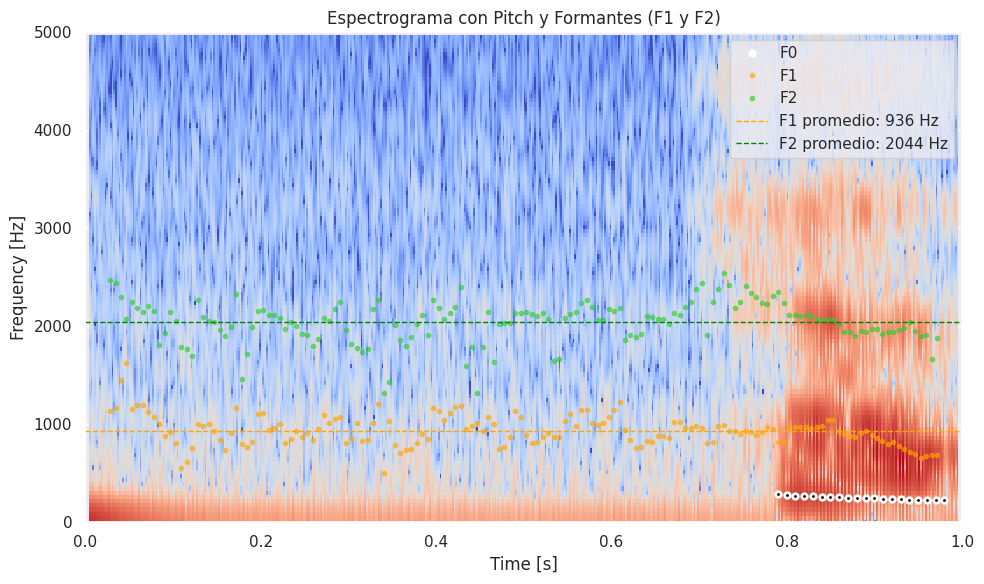

In [ ]:
grafica = spectrogram_graph(tiempos, f1_vals, f2_vals, f1_prom, f2_prom, snd)

In [ ]:
medias_genero = {
    "ae":{"male": [588, 1952],"female": [669, 2349]},
    "ih":{"male": [427, 2034],"female": [483, 2365]},
    "uh":{"male": [623, 1200],"female": [753, 1426]},    
}

In [ ]:
rango_f1 = [min(medias_genero[fonema]["male"][0], medias_genero[fonema]["female"][0]),
            max(medias_genero[fonema]["male"][0], medias_genero[fonema]["female"][0])]
rango_f2 = [min(medias_genero[fonema]["male"][1], medias_genero[fonema]["female"][1]),
            max(medias_genero[fonema]["male"][1], medias_genero[fonema]["female"][1])]

print(f"\nAnalizando la vocal: /{fonema}/")
print(f"Rango F1: {rango_f1} Hz")
print(f"Rango F2: {rango_f2} Hz")



Analizando la vocal: /ae/
Rango F1: [588, 669] Hz
Rango F2: [1952, 2349] Hz


In [ ]:
score_f1, score_f2, mean_score = calcular_score(f1_prom, f2_prom, rango_f1, rango_f2)
print("Calificación F1", score_f1, "\n", "Calificación F2", score_f2, "\n", "Promedio total:", mean_score)

Calificación F1 33.3198425901316 
 Calificación F2 100.0 
 Promedio total: 66.6599212950658


## Test del modelo

### Text model feedback

In [ ]:
from transformers import pipeline
# Cargar modelo y tokenizer entrenados
model_path_es = os.path.join("../data", "gpt2-pron-feedback_es")
tokenizer_es = os.path.join("../data", "gpt2-pron-feedback_es")

In [ ]:
f1_prom = 935
f2_prom = 2044
input_word = "has"
fonema = "ae"


In [ ]:
generator_es = pipeline("text-generation", model=model_path_es, tokenizer=tokenizer_es)
prompt_es = generar_prompt_es(fonema, f1_prom, f2_prom, input_word)
print(prompt_es)

Device set to use cuda:0


La vocal /æ/ fue pronunciada con F1=935Hz y F2=2044Hz. Para esta vocal, el valor esperado de F1 es 500Hz. La palabra practicada fue 'has'. Brinda una sugerencia específica para corregir el valor de F1.
Respuesta:


In [ ]:
respuesta_es = generator_es(prompt_es, max_new_tokens=70, do_sample=True, temperature=0.5)[0]["generated_text"]
print(respuesta_es)

La vocal /æ/ fue pronunciada con F1=935Hz y F2=2044Hz. Para esta vocal, el valor esperado de F1 es 500Hz. La palabra practicada fue 'has'. Brinda una sugerencia específica para corregir el valor de F1.
Respuesta: æ fue pronunciada con F2=935Hz y F2=2034Hz ʌ/. Intenta llevar la lengua hacia atrás o relajarla. Keep practicing the word and you'll improve quickly. 💪 💪 💪 💪 💪 �


In [ ]:
def generar_evidencia_aleatoria(num_pruebas=10, archivo_salida="evidencia_aleatoria.txt"):
    """ Genera datos de prueba aleatorios, llama a las funciones, genera texto con el modelo (variando la temperatura)
    y guarda los resultados en un archivo. """
    with open(archivo_salida, "w", encoding="utf-8") as f:
        for i in range(num_pruebas):
            # 1. Seleccionar una vocal aleatoria
            vocal_keys = list(vocales_info_base.keys())
            if not vocal_keys:
                print("Error: No hay vocales disponibles en vocales_info_base.")
                return

            vocal_key = random.choice(vocal_keys)

            # 2. Generar valores aleatorios de F1 y F2
            f1_prom = random.randint(rango_f1[0], rango_f1[1])
            f2_prom = random.randint(rango_f2[0], rango_f2[1])

            # 3. Seleccionar una palabra aleatoria
            palabras_posibles = [
                "cat", "hat", "bat", "cot", "cut",
                "beet", "bit", "bait", "bet", "but",
                "boot", "boat", "bought", "bout", "beat"
            ]
            input_word = random.choice(palabras_posibles)

            # 4. Calcular los scores
            score_f1, score_f2, mean_score = calcular_score(f1_prom, f2_prom, rango_f1, rango_f2)

            # 5. Generar el prompt
            prompt = generar_prompt_es(vocal_key, f1_prom, f2_prom, input_word)

            # 6. Generar la respuesta del modelo, variando la temperatura
            temperatura = random.uniform(0.2, 1.0)  # Rango de temperatura más común
            respuesta = generator_es(prompt, max_new_tokens=70, do_sample=True, temperature=temperatura)[0]["generated_text"]

            # 7. Escribir los resultados en el archivo
            f.write(f"Prueba {i + 1}:\n")
            f.write(f"  Vocal: {vocal_key}\n")
            f.write(f"  F1 Promedio: {f1_prom} Hz\n")
            f.write(f"  F2 Promedio: {f2_prom} Hz\n")
            f.write(f"  Palabra: {input_word}\n")
            f.write(f"  Score F1: {score_f1:.2f}\n")
            f.write(f"  Score F2: {score_f2:.2f}\n")
            f.write(f"  Mean Score: {mean_score:.2f}\n")
            f.write(f"  Temperatura: {temperatura:.2f}\n")  # Registra la temperatura usada
            f.write(f"  Prompt:\n{prompt}\n")
            f.write(f"  \n{respuesta}\n")
            f.write("-" * 40 + "\n")

    print(f"Se han generado {num_pruebas} pruebas aleatorias y se han guardado en el archivo: {archivo_salida}")

In [ ]:
path_evidence = os.path.join("../data", "datos_aleatorios_test.txt")
generar_evidencia_aleatoria(num_pruebas=10, archivo_salida=path_evidence)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Se han generado 10 pruebas aleatorias y se han guardado en el archivo: ../data/datos_aleatorios_test.txt


##### Versión en ingles

In [ ]:
model_path_en = os.path.join("../data", "gpt2-pron-feedback_en")
tokenizer_en = os.path.join("../data", "gpt2-pron-feedback_en")

In [ ]:
generator_en = pipeline("text-generation", model=model_path_en, tokenizer=tokenizer_en)
prompt_en = generar_prompt_en(fonema, f1_prom, f2_prom, input_word)

Device set to use cuda:0


In [ ]:
respuesta_en = generator_en(prompt_en, max_new_tokens=100, do_sample=True, temperature=0.1)[0]["generated_text"]
print(respuesta_en)

The vowel /æ/ was pronounced with F1=935Hz and F2=2044Hz. For this vowel, the expected F1 value is 500Hz. The practiced word was 'has'. Provide a specific suggestion to correct the F1 value.
Response: The expected values are F1=588-669Hz and F2=1952-2349Hz. Keep practicing the word and you'll improve quickly. 💪� 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 💪 �


In [ ]:
def generar_evidencia_aleatoria(num_pruebas=10, archivo_salida="evidencia_aleatoria_en.txt"):
    """ Genera datos de prueba aleatorios, llama a las funciones, genera texto con el modelo (variando la temperatura)
    y guarda los resultados en un archivo. """
    with open(archivo_salida, "w", encoding="utf-8") as f:
        for i in range(num_pruebas):
            # 1. Seleccionar una vocal aleatoria
            vocal_keys = list(vocales_info_base.keys())
            if not vocal_keys:
                print("Error: No hay vocales disponibles en vocales_info_base.")
                return

            vocal_key = random.choice(vocal_keys)

            # 2. Generar valores aleatorios de F1 y F2
            f1_prom = random.randint(rango_f1[0], rango_f1[1])
            f2_prom = random.randint(rango_f2[0], rango_f2[1])

            # 3. Seleccionar una palabra aleatoria
            palabras_posibles = [
                "cat", "hat", "bat", "cot", "cut",
                "beet", "bit", "bait", "bet", "but",
                "boot", "boat", "bought", "bout", "beat"
            ]
            input_word = random.choice(palabras_posibles)

            # 4. Calcular los scores
            score_f1, score_f2, mean_score = calcular_score(f1_prom, f2_prom, rango_f1, rango_f2)

            # 5. Generar el prompt
            prompt_en = generar_prompt_en(vocal_key, f1_prom, f2_prom, input_word)

            # 6. Generar la respuesta del modelo, variando la temperatura
            temperatura = random.uniform(0.2, 1.0)  # Rango de temperatura más común
            respuesta = generator_es(prompt_en, max_new_tokens=70, do_sample=True, temperature=temperatura)[0]["generated_text"]

            # 7. Escribir los resultados en el archivo
            f.write(f"Prueba {i + 1}:\n")
            f.write(f"  Vocal: {vocal_key}\n")
            f.write(f"  F1 Promedio: {f1_prom} Hz\n")
            f.write(f"  F2 Promedio: {f2_prom} Hz\n")
            f.write(f"  Palabra: {input_word}\n")
            f.write(f"  Score F1: {score_f1:.2f}\n")
            f.write(f"  Score F2: {score_f2:.2f}\n")
            f.write(f"  Mean Score: {mean_score:.2f}\n")
            f.write(f"  Temperatura: {temperatura:.2f}\n")  # Registra la temperatura usada
            f.write(f"  Prompt:\n{prompt_en}\n")
            f.write(f"  \n{respuesta}\n")
            f.write("-" * 40 + "\n")

    print(f"Se han generado {num_pruebas} pruebas aleatorias y se han guardado en el archivo: {archivo_salida}")

In [ ]:
path_evidence = os.path.join("../data", "datos_aleatorios_test.txt")
generar_evidencia_aleatoria(num_pruebas=10, archivo_salida=path_evidence)

Se han generado 10 pruebas aleatorias y se han guardado en el archivo: ../data/datos_aleatorios_test.txt
